In [1]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn import mixture
%matplotlib notebook
import csv

Import raster data

In [2]:
chm = gdal.Open('CHM_WH_1m.tif')

Convert raster data to an array

In [3]:
chm_pix = chm.ReadAsArray()
chm_pix.shape, np.bincount(chm_pix.ravel()) # Check the integers make sense

((729, 1746),
 array([274798, 886670,  12009,   9551,   8578,   8387,   8150,   8587,
          8446,   8524,   8821,   8384,   7425,   5798,   4054,   2343,
          1176,    487,    222,    143,    111,     90,     57,     17,
             3,      0,      2,      1], dtype=int64))

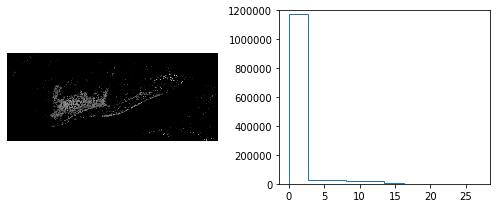

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(chm_pix, cmap='gray', vmin='1')
ax[1].hist(chm_pix.ravel(), histtype='step')
ax[1].set_ylim((0, 1200000))
ax[0].axis('off')
fig.tight_layout()

Start simple, loop through the pixels and apply the entropy formula to an area (*kernal*) of size $k\times k$ pixels, 

$$H' = \sum{p_i .\log_2 p_i}$$

where $p_i$ is the proportion of pixels in each integer interval $i$ within the kernal.

In [5]:
def entropy(p_n):
    '''The function, takes k by k size kernal'''
    w, h = p_n.shape
    p = np.bincount(p_n.ravel())/(w*h)
    return -(p[p!=0] * np.log2(p[p!=0])).sum()

Create a function to save the result of the GMM as an image

In [6]:
def clone_from_raster(to_clone, pixel_data, file_name, n_bands, dtype):
    
    geotransform = to_clone.GetGeoTransform()
    proj = to_clone.GetProjectionRef() 
    n_rows = to_clone.RasterYSize
    n_cols = to_clone.RasterXSize
    
    driver = gdal.GetDriverByName('HFA') # Imagine .img
    out_raster = driver.Create(
        file_name,
        n_cols,
        n_rows,
        n_bands,
        dtype
    )

    out_raster.SetGeoTransform(geotransform)
    out_raster.SetProjection(proj)

    out_raster.SetGeoTransform(geotransform)
    out_raster.SetProjection(proj)
    
    if n_bands != 1:
        for i in range(n_bands):
            outband = out_raster.GetRasterBand(i+1) 
            outband.WriteArray(pixel_data[i])
      
        

    
    else:
        outband = out_raster.GetRasterBand(1) 
        outband.WriteArray(pixel_data)
        
      
    out_raster = None
    return

## Window size = 5 x 5 m

In [7]:
k = 5 
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output5 = np.zeros(chm_pix.shape, dtype='float')

# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): 
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output5[i, j] = entropy(win)
        

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 725/725 [00:17<00:00, 41.61it/s]


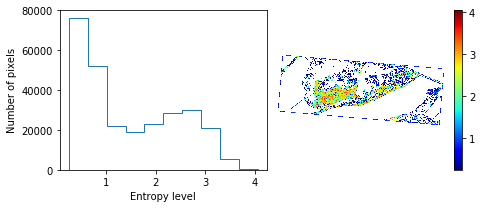

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output5.copy()
vis[output5==0] = np.nan

ax[0].hist(output5[output5!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output5.max(), interpolation='none')
plt.colorbar(im)
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')


ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k5_small.png')

In [9]:
clone_from_raster(chm, vis, "entropy_k5_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

Calculate mean, maximum and minum entropy values and write it to a file containing an overview for all window sizes in both scales of study area

In [10]:
mean_kernals = dict()
mean_kernal5 = np.mean(output5)
mean_kernals['5'] = mean_kernal5
mean_kernals

{'5': 0.3150555765726461}

In [11]:
max_kernals = dict()
max_kernal5 = np.max(output5)
max_kernals['5'] = max_kernal5
max_kernals

{'5': 4.0536606896881855}

In [12]:
min_kernals = dict()
min_kernal5 = np.min(output5)
min_kernals['5'] = min_kernal5
min_kernals

{'5': 0.0}

In [13]:
with open("overview_scales.csv", "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Scale', 'Window size', 'Mean', 'Maximum', 'Minimum'])


In [14]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '5', f'{mean_kernal5}', f'{max_kernal5}', f'{min_kernal5}'])

Perform a Gaussian Mixture model

In [8]:
nr, nc = output5.shape
reshaped = output5.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [9]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)
reshaped_noZero

array([[0.72192809],
       [0.94268319],
       [0.99884554],
       ...,
       [0.99884554],
       [0.94268319],
       [0.72192809]])

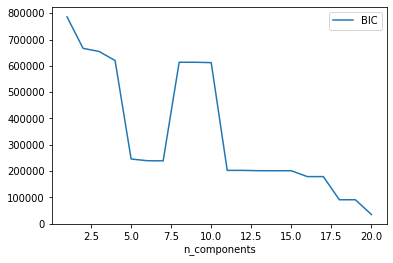

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k5_small.png')

In [10]:
gm_model = GaussianMixture(n_components= 6, n_init=10).fit(reshaped_noZero)

In [11]:
gm_labels = gm_model.predict(reshaped_noZero)

In [12]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
              
original_values = np.array(original_values)
original_values

array([nan, nan, nan, ..., nan, nan, nan])

In [13]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

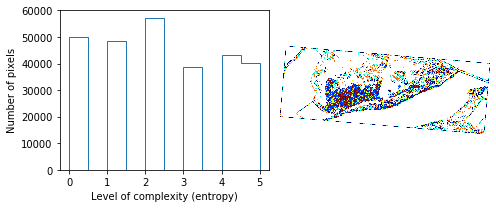

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output5==0] = np.nan


ax1 = ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k5_small.png')

In [15]:
clone_from_raster(chm, original_shape, "GMM_k5_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## Kernal size = 25

In [16]:
k = 25 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output25 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output25[i, j] = entropy(win)

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 705/705 [00:18<00:00, 37.16it/s]


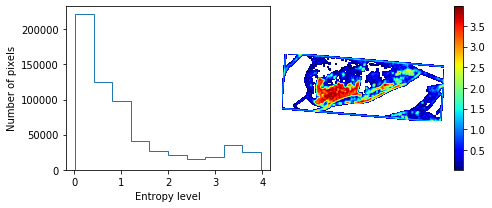

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output25.copy()
vis[output25==0] = np.nan

ax[0].hist(output25[output25!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output25.max(), interpolation='none')
plt.colorbar(im)
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')


ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k25_small.png')

In [26]:
clone_from_raster(chm, vis, "entropy_k25_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [27]:
mean_kernal25 = np.mean(output25)
mean_kernals['25'] = mean_kernal25
mean_kernals

{'5': 0.3150555765726461, '25': 0.5253094939126862}

In [28]:
max_kernal25 = np.max(output25)
max_kernals['25'] = max_kernal25
max_kernals

{'5': 4.0536606896881855, '25': 3.9706176477866135}

In [29]:
min_kernals = dict()
min_kernal25 = np.min(output25)
min_kernals['25'] = min_kernal25
min_kernals

{'25': 0.0}

In [30]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '25', f'{mean_kernal25}', f'{max_kernal25}', f'{min_kernal25}'])

In [17]:
nr, nc = output25.shape
reshaped25 = output25.reshape(nr*nc)
reshaped25_2 = reshaped25.reshape(-1,1)

In [18]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped25_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

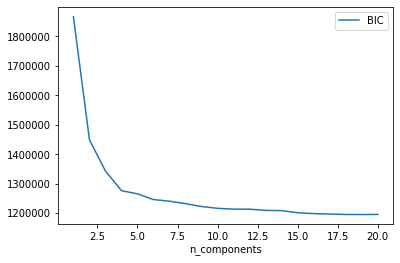

In [33]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k25_small.png')

Perform a Gaussian Mixture Model

In [19]:
gm_model25 = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [20]:
gm_labels25 = gm_model25.predict(reshaped_noZero)

In [21]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels25)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels25[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [22]:
original_shape25 = original_values.reshape(nr, nc)
original_shape25.shape

(729, 1746)

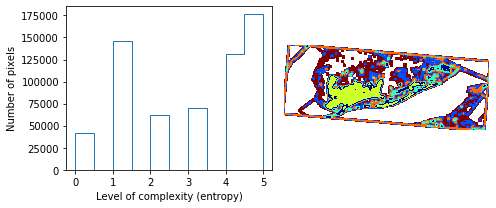

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape25.copy()
vis3 = vis2.astype(float)
vis3[output25==0] = np.nan

ax[0].hist(gm_labels25, histtype='step')
im3 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels25.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k25_small.png')

In [24]:
clone_from_raster(chm, original_shape25, "GMM_k25_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## Window size = 45 x 45 m

In [25]:
k = 45 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output45 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output45[i, j] = entropy(win)
        

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 685/685 [00:23<00:00, 28.15it/s]


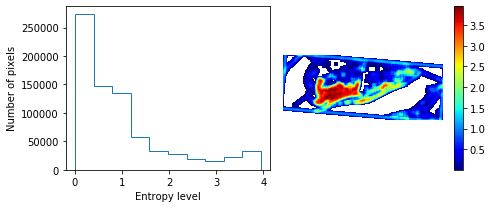

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output45.copy()
vis[output45==0] = np.nan

ax[0].hist(output45[output45!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output45.max(), interpolation='none')
plt.colorbar(im)
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k45_small.png')

In [42]:
clone_from_raster(chm, vis, "entropy_k45_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [43]:
mean_kernal45 = np.mean(output45)
mean_kernals['45'] = mean_kernal45
mean_kernals

{'5': 0.3150555765726461, '25': 0.5253094939126862, '45': 0.593399771474757}

In [44]:
max_kernal45 = np.max(output45)
max_kernals['45'] = max_kernal45
max_kernals

{'5': 4.0536606896881855, '25': 3.9706176477866135, '45': 3.949804304737787}

In [45]:
min_kernals = dict()
min_kernal45 = np.min(output45)
min_kernals['45'] = min_kernal45
min_kernals

{'45': 0.0}

In [46]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '45', f'{mean_kernal45}', f'{max_kernal45}', f'{min_kernal45}'])

In [26]:
nr, nc = output45.shape
reshaped = output45.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [27]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

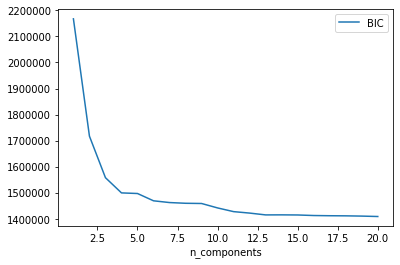

In [49]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k45_small.png')

In [28]:
gm_model = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [29]:
gm_labels = gm_model.predict(reshaped_noZero)

In [30]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [31]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

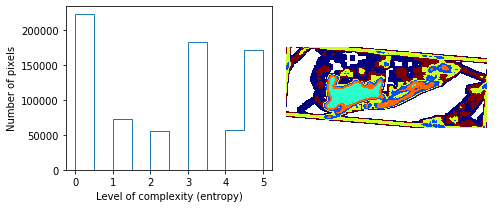

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output45==0] = np.nan

ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')


ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k45_small.png')

In [33]:
clone_from_raster(chm, original_shape, "GMM_k45_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## Window size = 65 x 65 m

In [34]:
k = 65 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output65 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output65[i, j] = entropy(win)

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 665/665 [00:31<00:00, 21.66it/s]


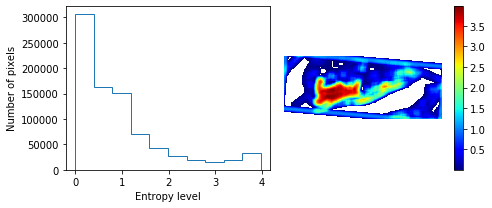

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output65.copy()
vis[output65==0] = np.nan

ax[0].hist(output65[output65!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output65.max(), interpolation='none')
plt.colorbar(im)
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k65_small.png')

In [58]:
clone_from_raster(chm, vis, "entropy_k65_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [59]:
mean_kernal65 = np.mean(output65)
mean_kernals['65'] = mean_kernal65
mean_kernals

{'5': 0.3150555765726461,
 '25': 0.5253094939126862,
 '45': 0.593399771474757,
 '65': 0.6341670699484352}

In [60]:
max_kernal65 = np.max(output65)
max_kernals['65'] = max_kernal65
max_kernals

{'5': 4.0536606896881855,
 '25': 3.9706176477866135,
 '45': 3.949804304737787,
 '65': 3.974339707433681}

In [61]:
min_kernals = dict()
min_kernal65 = np.min(output65)
min_kernals['65'] = min_kernal65
min_kernals

{'65': 0.0}

In [62]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '65', f'{mean_kernal65}', f'{max_kernal65}', f'{min_kernal65}'])

In [35]:
nr, nc = output65.shape
reshaped = output65.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [36]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

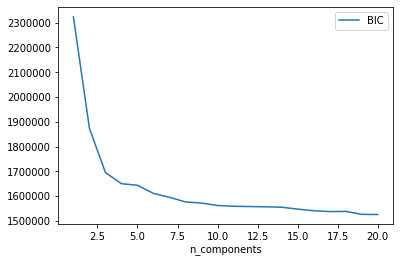

In [65]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k65_small.png')

In [37]:
gm_model = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [38]:
gm_labels = gm_model.predict(reshaped_noZero)

In [39]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [40]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

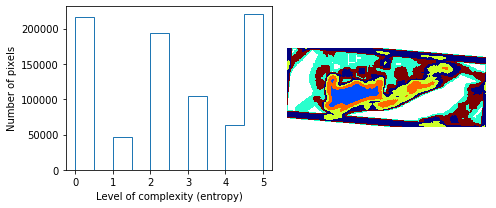

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output65==0] = np.nan

ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')


ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k65_small.png')

In [42]:
clone_from_raster(chm, original_shape, "GMM_k65_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## Window size = 85 x 85 m

In [43]:
k = 85 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output85 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output85[i, j] = entropy(win)

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 645/645 [00:40<00:00, 16.01it/s]


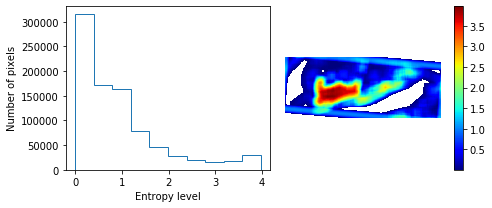

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output85.copy()
vis[output85==0] = np.nan

ax[0].hist(output85[output85!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output85.max(), interpolation='none')
plt.colorbar(im)
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k85_small.png')

In [74]:
clone_from_raster(chm, vis, "entropy_k85_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [75]:
mean_kernal85 = np.mean(output85)
mean_kernals['85'] = mean_kernal85
mean_kernals

{'5': 0.3150555765726461,
 '25': 0.5253094939126862,
 '45': 0.593399771474757,
 '65': 0.6341670699484352,
 '85': 0.6611782236643199}

In [76]:
max_kernal85 = np.max(output85)
max_kernals['85'] = max_kernal85
max_kernals

{'5': 4.0536606896881855,
 '25': 3.9706176477866135,
 '45': 3.949804304737787,
 '65': 3.974339707433681,
 '85': 3.973293773932056}

In [77]:
min_kernals = dict()
min_kernal85 = np.min(output85)
min_kernals['85'] = min_kernal85
min_kernals

{'85': 0.0}

In [78]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '85', f'{mean_kernal85}', f'{max_kernal85}', f'{min_kernal85}'])

In [44]:
nr, nc = output85.shape
reshaped = output85.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [45]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

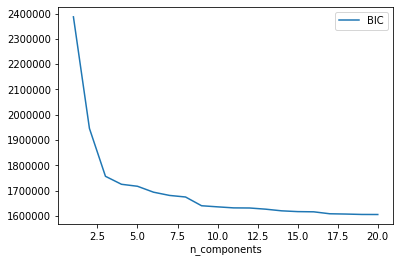

In [81]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k85_small.png')

In [46]:
gm_model = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [47]:
gm_labels = gm_model.predict(reshaped_noZero)

In [48]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [49]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

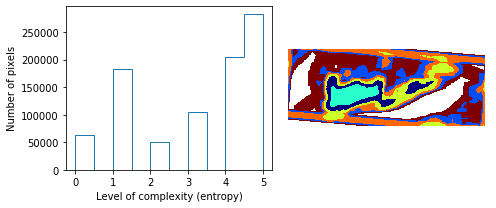

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output65==0] = np.nan

ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k85_small.png')

In [51]:
clone_from_raster(chm, original_shape, "GMM_k85_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## Window size = 105 x 105 m

In [52]:
k = 105 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output105 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output105[i, j] = entropy(win)

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 625/625 [00:50<00:00, 12.36it/s]


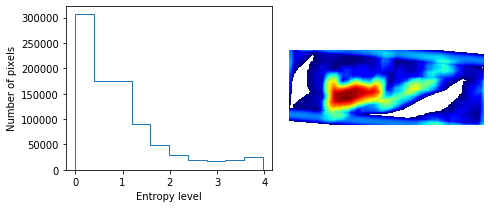

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output105.copy()
vis[output105==0] = np.nan

ax[0].hist(output105[output105!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output105.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k105_small.png')

In [90]:
clone_from_raster(chm, vis, "entropy_k105_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [91]:
mean_kernal105 = np.mean(output105)
mean_kernals['105'] = mean_kernal105
mean_kernals

{'5': 0.3150555765726461,
 '25': 0.5253094939126862,
 '45': 0.593399771474757,
 '65': 0.6341670699484352,
 '85': 0.6611782236643199,
 '105': 0.6787081816146727}

In [92]:
max_kernal105 = np.max(output105)
max_kernals['105'] = max_kernal105
max_kernals

{'5': 4.0536606896881855,
 '25': 3.9706176477866135,
 '45': 3.949804304737787,
 '65': 3.974339707433681,
 '85': 3.973293773932056,
 '105': 3.9717330953487173}

In [93]:
min_kernals = dict()
min_kernal105 = np.min(output105)
min_kernals['105'] = min_kernal105
min_kernals

{'105': 0.0}

In [94]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '105', f'{mean_kernal105}', f'{max_kernal105}', f'{min_kernal105}'])

In [53]:
nr, nc = output105.shape
reshaped = output105.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [54]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

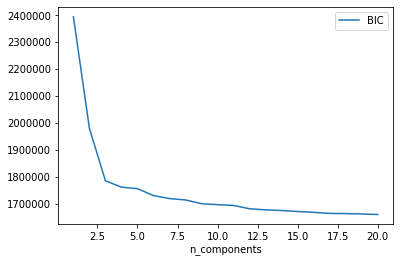

In [97]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k105_small.png')

In [55]:
gm_model = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [56]:
gm_labels = gm_model.predict(reshaped_noZero)

In [57]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [58]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

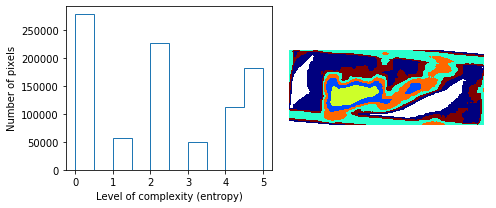

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output105==0] = np.nan

ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k105_small.png')

In [60]:
clone_from_raster(chm, original_shape, "GMM_k105_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

## window size = 125 x 125 m

In [61]:
k = 125 # Change to see the effect of larger kernal (must be odd)
nrows, ncols = chm_pix.shape
offset = int(k*.5)

output125 = np.zeros(chm_pix.shape, dtype='float')


# Loop the pixels, avoiding the edges of the array
for i in tqdm(np.arange(offset, nrows-offset, 1), desc='Rows'): # tdqm is the progress bar
    for j in np.arange(offset, ncols-offset, 1):
        win = chm_pix[i-offset:i+offset+1, j-offset:j+offset+1]
        output125[i, j] = entropy(win)

Rows: 100%|██████████████████████████████████████████████████████████████████████████| 605/605 [00:59<00:00, 10.11it/s]


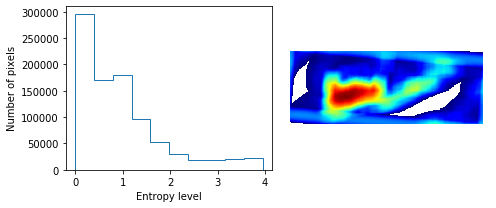

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis = output125.copy()
vis[output125==0] = np.nan

ax[0].hist(output125[output125!=0], histtype='step')
im = ax[1].imshow(vis, cmap='jet', vmax=output125.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Entropy level', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('entropy_k125_small.png')

In [106]:
clone_from_raster(chm, vis, "entropy_k125_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)

In [107]:
mean_kernal125 = np.mean(output125)
mean_kernals['125'] = mean_kernal125
mean_kernals

{'5': 0.3150555765726461,
 '25': 0.5253094939126862,
 '45': 0.593399771474757,
 '65': 0.6341670699484352,
 '85': 0.6611782236643199,
 '105': 0.6787081816146727,
 '125': 0.688626146105957}

In [108]:
max_kernal125 = np.max(output125)
max_kernals['125'] = max_kernal125
max_kernals

{'5': 4.0536606896881855,
 '25': 3.9706176477866135,
 '45': 3.949804304737787,
 '65': 3.974339707433681,
 '85': 3.973293773932056,
 '105': 3.9717330953487173,
 '125': 3.955791521021368}

In [109]:
min_kernals = dict()
min_kernal125 = np.min(output125)
min_kernals['125'] = min_kernal125
min_kernals

{'125': 0.0}

In [110]:
 with open("overview_scales.csv", 'a', newline='') as f:
                fwriter = csv.writer(f)
                fwriter.writerow(['Small scale', '125', f'{mean_kernal125}', f'{max_kernal125}', f'{min_kernal125}'])

In [62]:
nr, nc = output125.shape
reshaped = output125.reshape(nr*nc)
reshaped_2 = reshaped.reshape(-1,1)

In [63]:
reshaped_noZero = []
reshaped_T_F = []
for i in reshaped_2:
    if i != 0:
        reshaped_noZero.append(i)
        reshaped_T_F.append(1)
    else:
        reshaped_T_F.append(0)
reshaped_noZero = np.array(reshaped_noZero)
reshaped_T_F = np.array(reshaped_T_F)

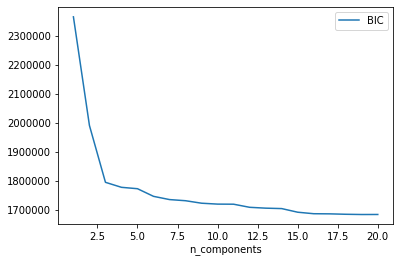

In [113]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(reshaped_noZero)
          for n in n_components]

plt.plot(n_components, [m.bic(reshaped_noZero) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('BIC_k125_small.png')

In [64]:
gm_model = GaussianMixture(n_components=6, n_init=10).fit(reshaped_noZero)

In [65]:
gm_labels = gm_model.predict(reshaped_noZero)

In [66]:
original_values = []
pos = 0
gm_labels_list = list(gm_labels)
for j in reshaped_T_F:
    if j==1 and pos<len(gm_labels_list):
        original_values.append(gm_labels[pos])
        pos += 1
    else:
        original_values.append(np.nan)
original_values = np.array(original_values)

In [67]:
original_shape = original_values.reshape(nr, nc)
original_shape.shape

(729, 1746)

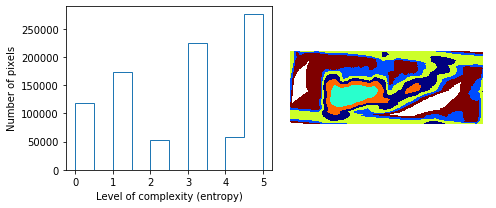

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Set the zeros to nan for visualisation
vis2 = original_shape.copy()
vis3 = vis2.astype(float)
vis3[output125==0] = np.nan

ax[0].hist(gm_labels, histtype='step')
im2 = ax[1].imshow(vis2, cmap='jet', vmax=gm_labels.max(), interpolation='none')
for a in ax.flat:
    a.set(xlabel='Level of complexity (entropy)', ylabel='Number of pixels')

ax[1].axis('off')
fig.tight_layout()
plt.savefig('GMM_k125_small.png')

In [69]:
clone_from_raster(chm, original_shape, "GMM_k125_small.tif", n_bands = 1, dtype = gdal.GDT_Float32)